## Import Dependencies

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
# Import helper functions
from helper_functions import create_tensorboard_callback,plot_loss_curves,unzip_data,walk_through_dir

--2023-02-13 04:34:52--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-02-13 04:34:53 (64.1 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## Get the data

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Tensorflow_Certificate/spam.csv')

In [ ]:
df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Preprocess

### Label Encoding

Note: Since the label is text, we need to encode it

In [ ]:
# Label Encoding for Label Column
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()

df['label_encoded'] = labelencoder.fit_transform(df['label'])

In [ ]:
df.head()

,label,text,label_encoded
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [ ]:
df['label'].value_counts()
# df['label'].nunique()

ham     4825
spam     747
Name: label, dtype: int64

In [ ]:
# Get class names and number of classes from LabelEncoder instance 
num_classes = len(labelencoder.classes_)
class_names = labelencoder.classes_
num_classes, class_names

(2, array(['ham', 'spam'], dtype=object))

### Convert to Lower Case

As a dimensionality reduction

In [ ]:
# df['text'] = df['text'].map(lambda x: )

## Split the data

In [ ]:
from sklearn.model_selection import train_test_split

train_sent,test_sent,train_labels,test_labels = train_test_split(df['text'].to_numpy(),
                                                                 df['label_encoded'].to_numpy(),
                                                                 random_state=42,
                                                                 test_size=0.1)

In [ ]:
len(train_sent),len(test_sent),len(train_labels),len(test_labels)

(5014, 558, 5014, 558)

## Text Vectorization

### Finding output Sequence Length

In [ ]:
# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sent]
avg_sent_len = np.mean(sent_lens)
avg_sent_len # return average sentence length (in tokens)

15.522337455125648

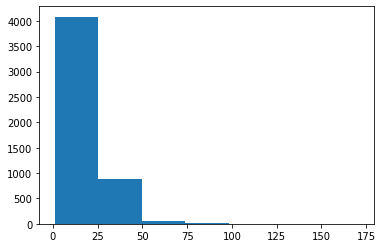

In [ ]:
# What's the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=7);

In [ ]:
# How long of a sentence covers 95% of the lengths?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

32

### Finding Vocab Length

In [ ]:
# Concatinating all the words to a single list
master_vocab_list = []
for sent in df['text']:
  master_vocab_list = master_vocab_list + sent.split()

In [ ]:
# Checking the length of all tokens (words)
len(master_vocab_list)

86335

In [ ]:
# Checking the length of unique tokens
len(set(master_vocab_list))

15585

### Creating Vectorizer

In [ ]:
# Setup text vectorization variables
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

max_vocab_length = 15585
max_length = 32

text_vectorizer = TextVectorization(max_tokens=max_vocab_length, #How many different words in the vocabulary (automatically add <oov>)
                                    standardize = 'lower_and_strip_punctuation',
                                    output_mode='int', # how to map tokens to numbers
                                    output_sequence_length=max_length, # how long do you want your sequence to be
                                    )

### Fitting the vectorizer 

In [ ]:
text_vectorizer.adapt(train_sent)

## Text Embedding

In [ ]:
# Create token embedding layer
from tensorflow.keras import layers
token_embed = layers.Embedding(input_dim=max_vocab_length, # length of vocabulary
                               output_dim=128, # Note: different embedding sizes result in drastically different numbers of parameters to train
                               # Use masking to handle variable sequence lengths (save space)
                               mask_zero=True,
                               name="token_embedding") 

## Creating Data Sets

In [ ]:
# Turn our data into TensorFlow Datasets
import tensorflow as tf 

train_dataset = tf.data.Dataset.from_tensor_slices((train_sent, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sent, test_labels))

train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
# Take the TensorSliceDataset's and turn them into prefetched batches
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

# Model 1: Convolutional 1D

In [ ]:
# Create 1D convolutional model to process sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = token_embed(text_vectors) # create embedding
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector
outputs = layers.Dense(1, activation="sigmoid")(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile
model_1.compile(loss=tf.keras.losses.BinaryCrossentropy(), # if your labels are integer form (not one hot) use sparse_categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Fit the model
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)), # only fit on 10% of batches for faster training time
                              epochs=5,
                              validation_data=test_dataset,
                              validation_steps=int(0.1 * len(test_dataset))) # only validate on 10% of batches

Epoch 1/5
15/15 [==============================] - 2s 46ms/step - loss: 0.4791 - accuracy: 0.9208 - val_loss: 0.2912 - val_accuracy: 0.9688
Epoch 2/5
15/15 [==============================] - 1s 34ms/step - loss: 0.1676 - accuracy: 0.9646 - val_loss: 0.1430 - val_accuracy: 0.9688
Epoch 3/5
15/15 [==============================] - 1s 36ms/step - loss: 0.0799 - accuracy: 0.9771 - val_loss: 0.0928 - val_accuracy: 0.9688
Epoch 4/5
15/15 [==============================] - 1s 50ms/step - loss: 0.0441 - accuracy: 0.9917 - val_loss: 0.0666 - val_accuracy: 0.9688
Epoch 5/5
15/15 [==============================] - 1s 55ms/step - loss: 0.0463 - accuracy: 0.9896 - val_loss: 0.0584 - val_accuracy: 0.9688


In [ ]:
model_1.evaluate(test_dataset)

18/18 [==============================] - 0s 6ms/step - loss: 0.0619 - accuracy: 0.9821


[0.06186101213097572, 0.9820788502693176]

In [ ]:
# Make predictions (our model outputs prediction probabilities for each class)
model_1_pred_probs = model_1.predict(test_dataset)
model_1_pred_probs

In [ ]:
# Convert pred probs to classes
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:5]

<tf.Tensor: shape=(5,), dtype=float32, numpy=array([1., 0., 1., 0., 1.], dtype=float32)>

In [ ]:
model_1.predict(['We know someone who you know that fancies you. Call 09058097218 to find out who. POBox 6, LS15HB 150p'])

1/1 [==============================] - 0s 64ms/step


array([[0.50761724]], dtype=float32)

In [ ]:
list(test_dataset)[0][0][2]

<tf.Tensor: shape=(), dtype=string, numpy=b'We know someone who you know that fancies you. Call 09058097218 to find out who. POBox 6, LS15HB 150p'>

In [ ]:
list(test_dataset)[0][1][2]

<tf.Tensor: shape=(), dtype=int64, numpy=1>

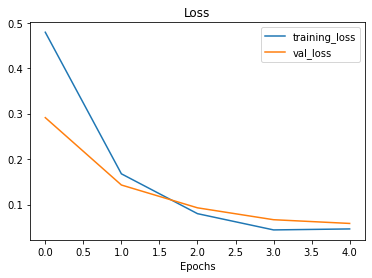

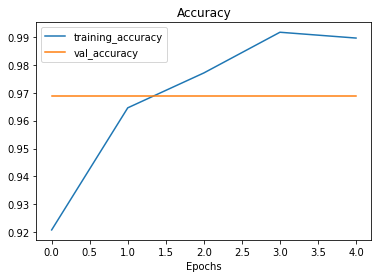

In [ ]:
plot_loss_curves(model_1_history)

## To Do: 

1. Fit other Models
2. Create callbacks
3. Save and Load the Model
4. Load from Checkpoint weights
5. Figure out why cannot run for larger epochs

# Multi Class Clssification

https://www.tensorflow.org/datasets/catalog/ag_news_subset

## Downloading TensorFlow dataset

In [ ]:
import tensorflow_datasets.public_api as tfds
import tensorflow as tf

In [23]:
train_ds, val_ds, test_ds = tfds.load('ag_news_subset',
                                      split=['train[:70%]', 'train[70%:85%]', 'train[85%:]'],
                                      shuffle_files=True, as_supervised=True,
                                      batch_size=32)

In [24]:
NUM_TRAIN_IMAGES = tf.data.experimental.cardinality(train_ds).numpy()
print("Num training samples: " + str(NUM_TRAIN_IMAGES))

NUM_VAL_IMAGES = tf.data.experimental.cardinality(val_ds).numpy()
print("Num validating samples: " + str(NUM_VAL_IMAGES))

NUM_TEST_IMAGES = tf.data.experimental.cardinality(test_ds).numpy()
print("Num testing samples: " + str(NUM_TEST_IMAGES))

Num training samples: 2625
Num validating samples: 563
Num testing samples: 563


In [29]:
for review_batch, label_batch in train_ds.take(1):
  
  for i in range(5):
    print("Review: ", review_batch[i])
    print("Label: ", label_batch[i])

Review:  tf.Tensor(b'AMD #39;s new dual-core Opteron chip is designed mainly for corporate computing applications, including databases, Web services, and financial transactions.', shape=(), dtype=string)
Label:  tf.Tensor(3, shape=(), dtype=int64)
Review:  tf.Tensor(b'Reuters - Major League Baseball\\Monday announced a decision on the appeal filed by Chicago Cubs\\pitcher Kerry Wood regarding a suspension stemming from an\\incident earlier this season.', shape=(), dtype=string)
Label:  tf.Tensor(1, shape=(), dtype=int64)
Review:  tf.Tensor(b'President Bush #39;s  quot;revenue-neutral quot; tax reform needs losers to balance its winners, and people claiming the federal deduction for state and local taxes may be in administration planners #39; sights, news reports say.', shape=(), dtype=string)
Label:  tf.Tensor(2, shape=(), dtype=int64)
Review:  tf.Tensor(b'Britain will run out of leading scientists unless science education is improved, says Professor Colin Pillinger.', shape=(), dtype=